<h1 align="center">Machine Learning</h1>
<h2 align="center">Support Vector Machine</h2>


<h3 align="center">The workflow</h3>

| Steps  |         Workflow          |                                               Notes |
|:-------|:-------------------------:|----------------------------------------------------:|
| Step 1 |         Ideation          |         Predict positive moves from a given dataset |
| Step 2 |      Data Collection      |                  Load the dataset from AlphaVantage |
| Step 3 |       Data Cleaning       |                                Cleaning the dataset |
| Step 4 | Exploratory Data Analysis |                                  Summary statistics |
| Step 5 |      Transformation       |                       Perform feature scaling based |
| Step 6 |         Modeling          |        Building and training Support vector machine |
| Step 7 |          Metrics          | Validating the model performance using score method |
| Step 8 |       Hyper tuning        |          Tuning the model to get better performance |
| Step 9 |        Conclusion         |                          Conclusion of the analysis |

<h3 align="center">Import dependencies</h3>

In [1]:
from matplotlib import pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, RocCurveDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

<h3 align="center">Data Collection</h3>
<h4 align="center">Get the data from AlphaVantage for the QQQ</h4>

In [2]:
# As I used Alpha Vantage for data collection I have put in the zip file a csv file containing the raw data
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=QQQ&outputsize=full&apikey={key}'
r = requests.get(url)
data = r.json()

<h3 align="center">Data Cleaning</h3>
<h4 align="center">Create processing/transforming function for the raw data + creating the features and target</h4>

In [3]:
# Drop the unnecessary columns from the raw data
def data_frame_creation(x: dict):
    df = pd.DataFrame(x['Time Series (Daily)']).T
    df.drop(columns = ['5. adjusted close', '6. volume', '7. dividend amount', '8. split coefficient'], inplace = True)
    df = df.astype(float)
    df.sort_index(ascending= True, inplace= True)
    return df

In [4]:
# Load the raw data using the function data_frame_creation created in section Data Collection
df_raw = data_frame_creation(data)

In [5]:
# Descriptive Statistics
df_raw.describe()

,1. open,2. high,3. low,4. close
count,5933.000000,5933.000000,5933.000000,5933.000000
mean,109.288124,110.215238,108.253174,109.292932
std,94.098983,94.867029,93.258218,94.136001
min,19.940000,20.530000,19.760000,20.060000
25%,41.440000,41.770000,41.000000,41.343000
50%,66.705000,67.150000,66.350000,66.660000
75%,149.600000,151.990000,148.530000,149.900000
max,405.570000,408.710000,402.580000,403.990000


In [6]:
# Checking for nulls/missing values
df_raw.isnull().sum()

1. open     0
2. high     0
3. low      0
4. close    0
dtype: int64

<h3 align="center">Transformation</h3>
<h4 align="center">Feature Engineering</h4>

In [7]:
# Create the features and target
def feature_target_creation(x: pd.DataFrame):
    x_copy = x.copy()
    x_copy['5. sign']= np.log(x_copy['4. close']/ x_copy['4. close'].shift(1))
    x_copy['6. past_return']= x_copy['5. sign'].shift(2)
    x_copy['7. momentum']= x_copy['4. close'] - x_copy['4. close'].shift(1)
    x_copy['8. moving_average']= x_copy['4. close'].rolling(7).mean()
    # x_copy['8. moving_average20']= x_copy['4. close'].rolling(20).mean()
    x_copy['9. exponential_moving_average']= x_copy['4. close'].ewm(span=7, adjust= False).mean()
    # x_copy['9. exponential_moving_average20']= x_copy['4. close'].ewm(span=20, adjust= False).mean()
    x_copy['target'] =np.where(x_copy['4. close'].shift(-1) >  0.995* x_copy['4. close'], 1,0)
    x_copy.dropna(inplace=True)
    return x_copy

In [8]:
df_full = feature_target_creation(df_raw)

In [9]:
X_mu = df_full[['1. open','2. high', '3. low', '4. close', '5. sign', '6. past_return', '7. momentum', '8. moving_average', '9. exponential_moving_average']]
y_mu = df_full['target']


<h4 align="left">Feature filtering</h4>
Mutual information

This method measures the amount of information shared between each feature and the target variable, and selects features with high mutual information values

In [10]:
mu_scores = mutual_info_classif(X_mu, y_mu)
print("Mutual information values:")
print(mu_scores)

Mutual information values:
[0.00364342 0.         0.0073798  0.01428039 0.00273687 0.01823115
 0.00703103 0.00541166 0.00219005]


In [11]:
# Drop OHLC as they are highly correlated with one another and other features and have low Mutual information values
df_clean = df_full.drop(['1. open', '2. high', '3. low', '4. close'], axis=1)

<Axes: xlabel='variable', ylabel='value'>

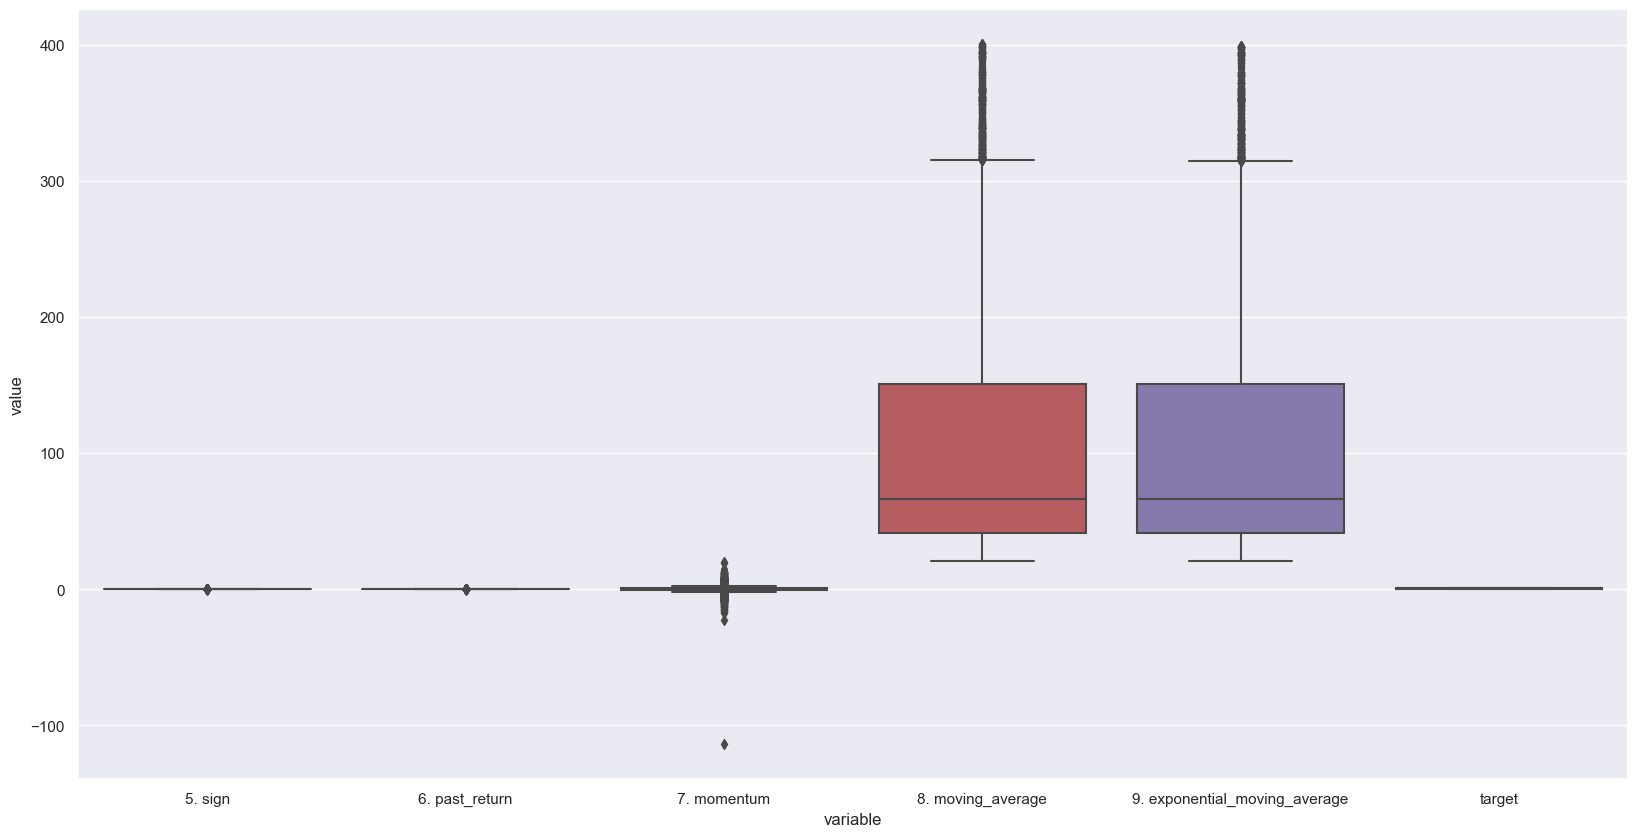

In [12]:
sns.set(rc={'figure.figsize': (20, 10)})
sns.boxplot(x= 'variable', y = 'value', data = pd.melt(df_clean))

In [13]:
df_clean.shape

(5927, 6)

Text(0.5, 1.0, 'Features Set Correlations heatmap')

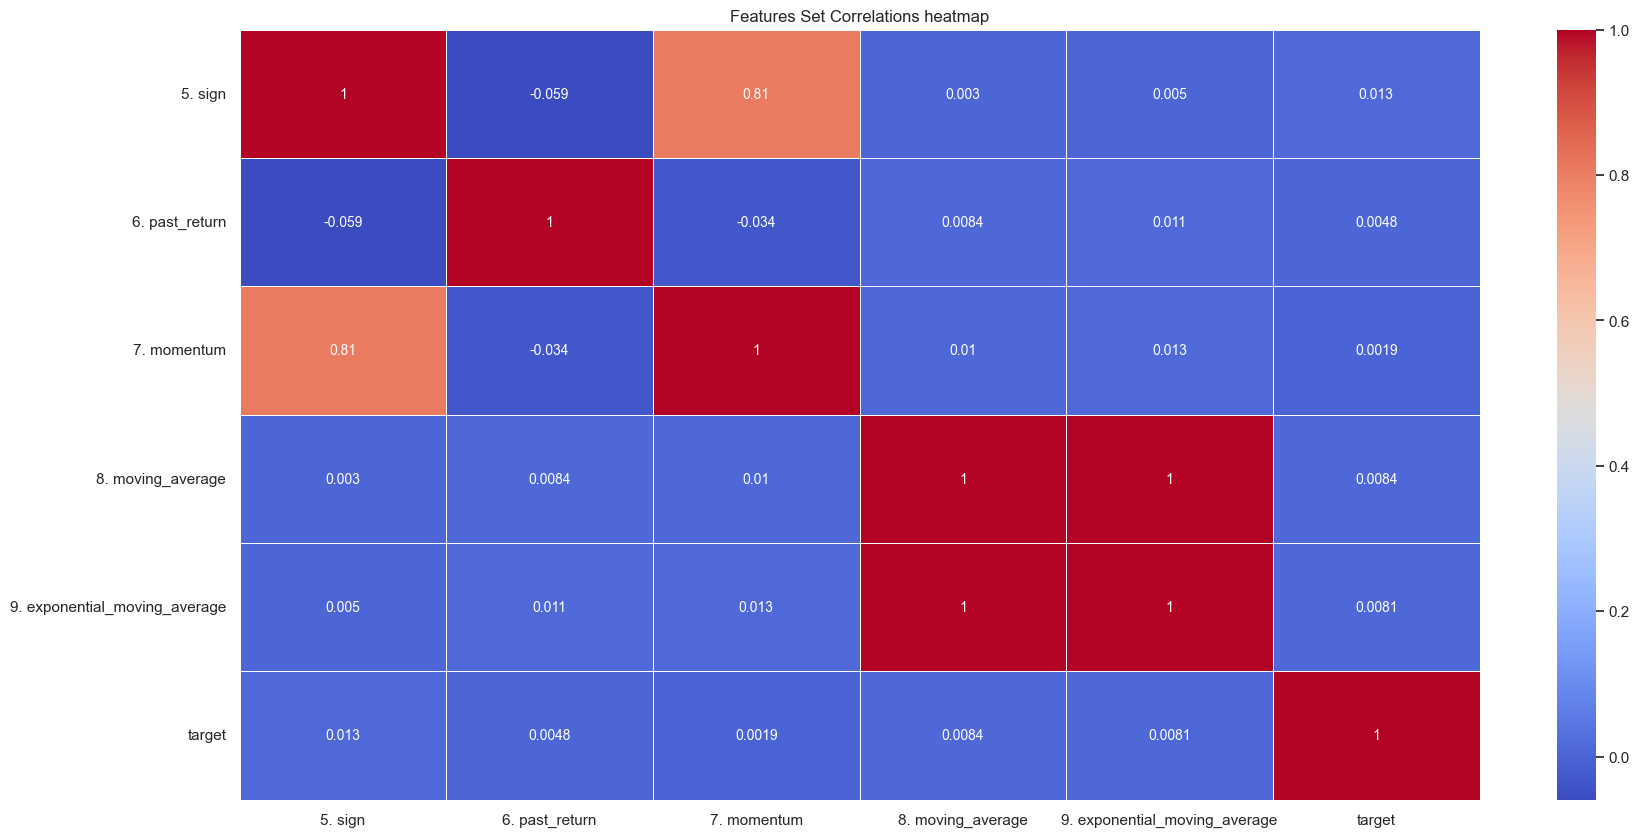

In [14]:
sns.set(rc={'figure.figsize': (20, 10)})
sns.heatmap(df_clean.corr(),
            annot= True,
            annot_kws={'size':10},
            fmt = '.2g',
            linewidths= .6,
            cmap= 'coolwarm',
            cbar= True)
plt.title('Features Set Correlations heatmap')

Text(0.5, 1.0, 'Features Set with Correlations higher than 0.90')

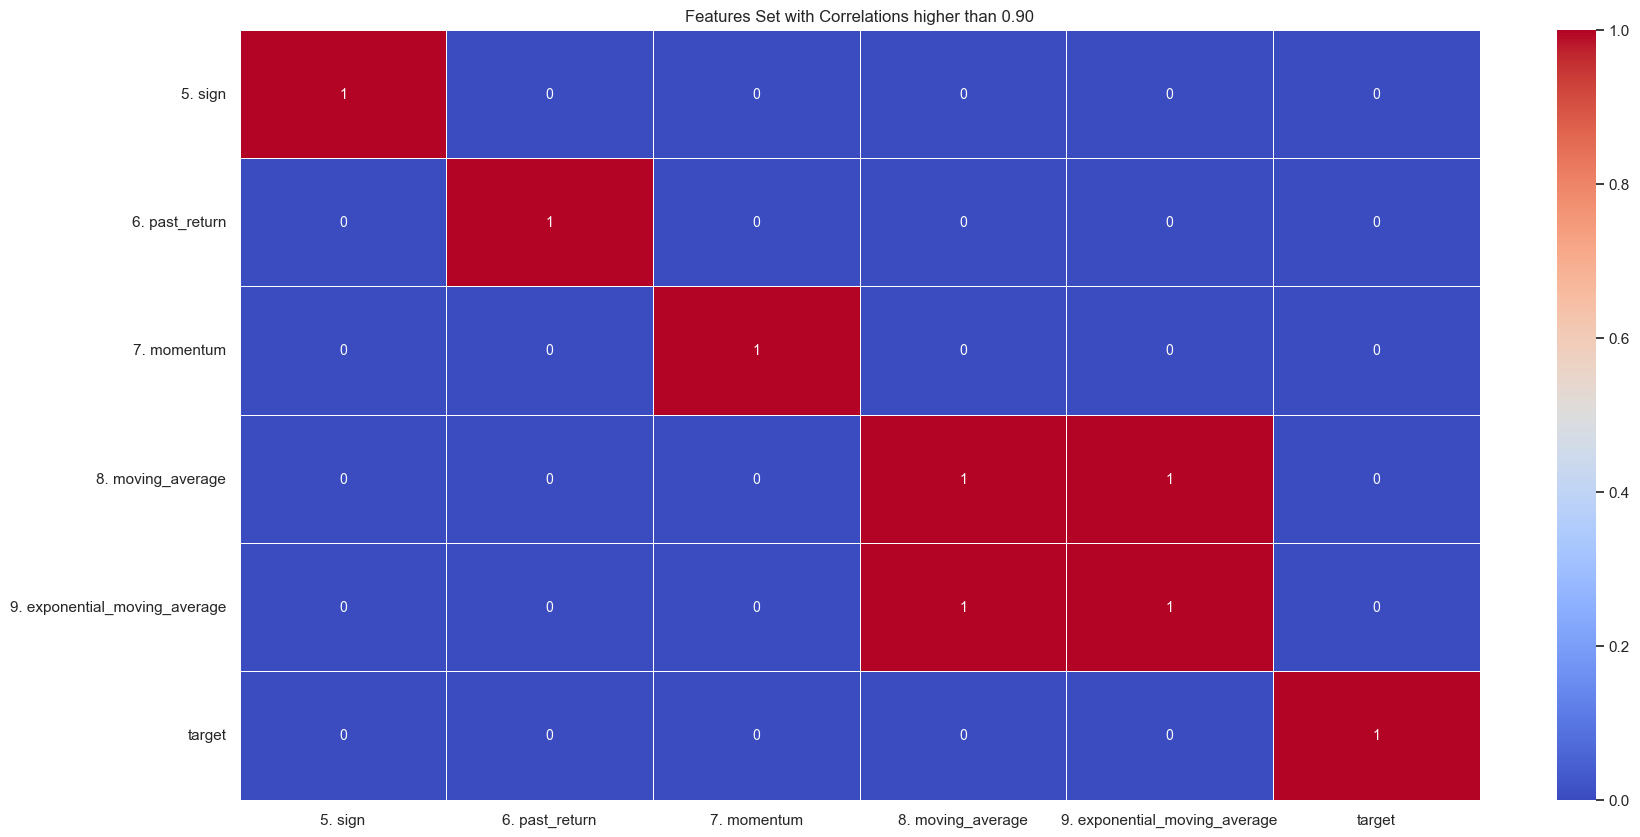

In [15]:
# remove features that are highly correlated
sns.heatmap(df_clean.corr()>0.9,
            annot= True,
            annot_kws={'size':10},
            fmt = '.2g',
            linewidths= .6,
            cmap= 'coolwarm',
            cbar= True)
plt.title('Features Set with Correlations higher than 0.90')

In [16]:
# Dropping highly correlated features, features with high mutual information score and remove target column
X = df_clean.drop(['9. exponential_moving_average', 'target'],axis= 1)
X_full = df_clean.copy()
# Putting target into y variable
y = df_clean['target']

# Record the feature names
features = X.columns

<h3 align="center">Transformation and modeling</h3>
<h4 align="center">Support Vector Class</h4>

In [17]:
# Support vector class creation
class SupportVector:
    def __init__(self, data_x:pd.DataFrame, data_y:pd.DataFrame, test_size=.20):
        self.X = data_x
        self.y = data_y
        self.test_size = test_size

        # Splitting the data into test and train
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=self.test_size,
                                                                                random_state=0, shuffle=False)
        print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)
    # Fit and predict
    def fit_predict(self, estimator, transformer):
            # creating a pipeline
            pipe = Pipeline([('scaler', transformer),('svc', estimator)]) # I will use Normalizer to normalize the data as there are features like moving average which are not on the same scale as other
            # fit/train model
            pipe.fit(self.X_train, self.y_train)
            # predict labels
            y_pred = pipe.predict(self.X_test)
            return pipe, y_pred

    # evaluate metrics
    def eval_metrics(self,model, y_pred):
        # evaluate metrics
        mse = mean_squared_error(self.y_test, y_pred, squared=True)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        # evaluate accuracy
        accuracy_train = accuracy_score(self.y_train, model.predict(self.X_train))
        accuracy_test = accuracy_score(self.y_test, y_pred)

        return print(f'Train Accuracy: {accuracy_train:0.5}, Test Accuracy: {accuracy_test:0.5}, MSE:{mse:0.5}, RMSE:{rmse:0.5}')

    #Plot Confussion Matrix
    def confussion_matrix(self,estimator, transformer):
        con_mat = ConfusionMatrixDisplay.from_estimator(self.fit_predict(estimator, transformer)[0], self.X_test, self.y_test,
        display_labels=sp_model_norm.classes_, cmap=plt.cm.Purples)
        con_mat.ax_.set_title('Confusion matrix')
        plt.show()

    # Plot ROC curve
    def roc_curve(self,estimator, transformer):
        display_roc = RocCurveDisplay.from_estimator(self.fit_predict(estimator, transformer)[0], self.X_test, self.y_test, name='SVM')
        display_roc.ax_.set_title('ROC Curve')
        plt.plot([0,1], [0,1])
        plt.show()


In [18]:
sp = SupportVector(X,y)
sp_full = SupportVector(X_full, y)

(4741, 4) (1186, 4) (4741,) (1186,)
(4741, 6) (1186, 6) (4741,) (1186,)


In [19]:
sp.__init__(X,y)
sp_full.__init__(X_full,y)

(4741, 4) (1186, 4) (4741,) (1186,)
(4741, 6) (1186, 6) (4741,) (1186,)


<h3 align="center">Metrics</h3>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=0, shuffle=False)

In [21]:
sp_model_norm, sp_y_pred_norm = sp.fit_predict(SVC(), Normalizer())
sp.eval_metrics(sp_model_norm, sp_y_pred_norm)
sp_full_model_norm, sp_full_y_pred_norm =sp_full.fit_predict(SVC(), Normalizer())

Train Accuracy: 0.71736, Test Accuracy: 0.70152, MSE:0.29848, RMSE:0.54634


In [22]:
sp_y_pred_norm

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
print(classification_report(y_test, sp_y_pred_norm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       354
           1       0.70      1.00      0.82       832

    accuracy                           0.70      1186
   macro avg       0.35      0.50      0.41      1186
weighted avg       0.49      0.70      0.58      1186



C:\Users\renar\PycharmProjects\CQF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\renar\PycharmProjects\CQF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\renar\PycharmProjects\CQF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


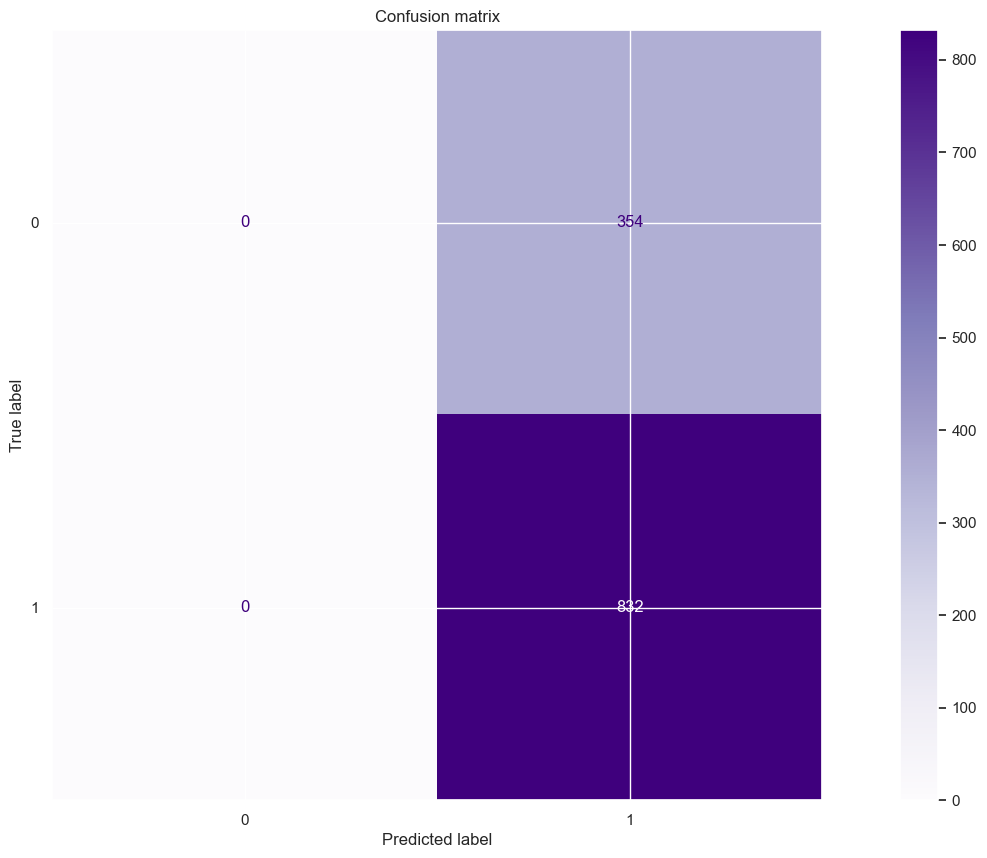

In [24]:
sp.confussion_matrix(SVC(), Normalizer())

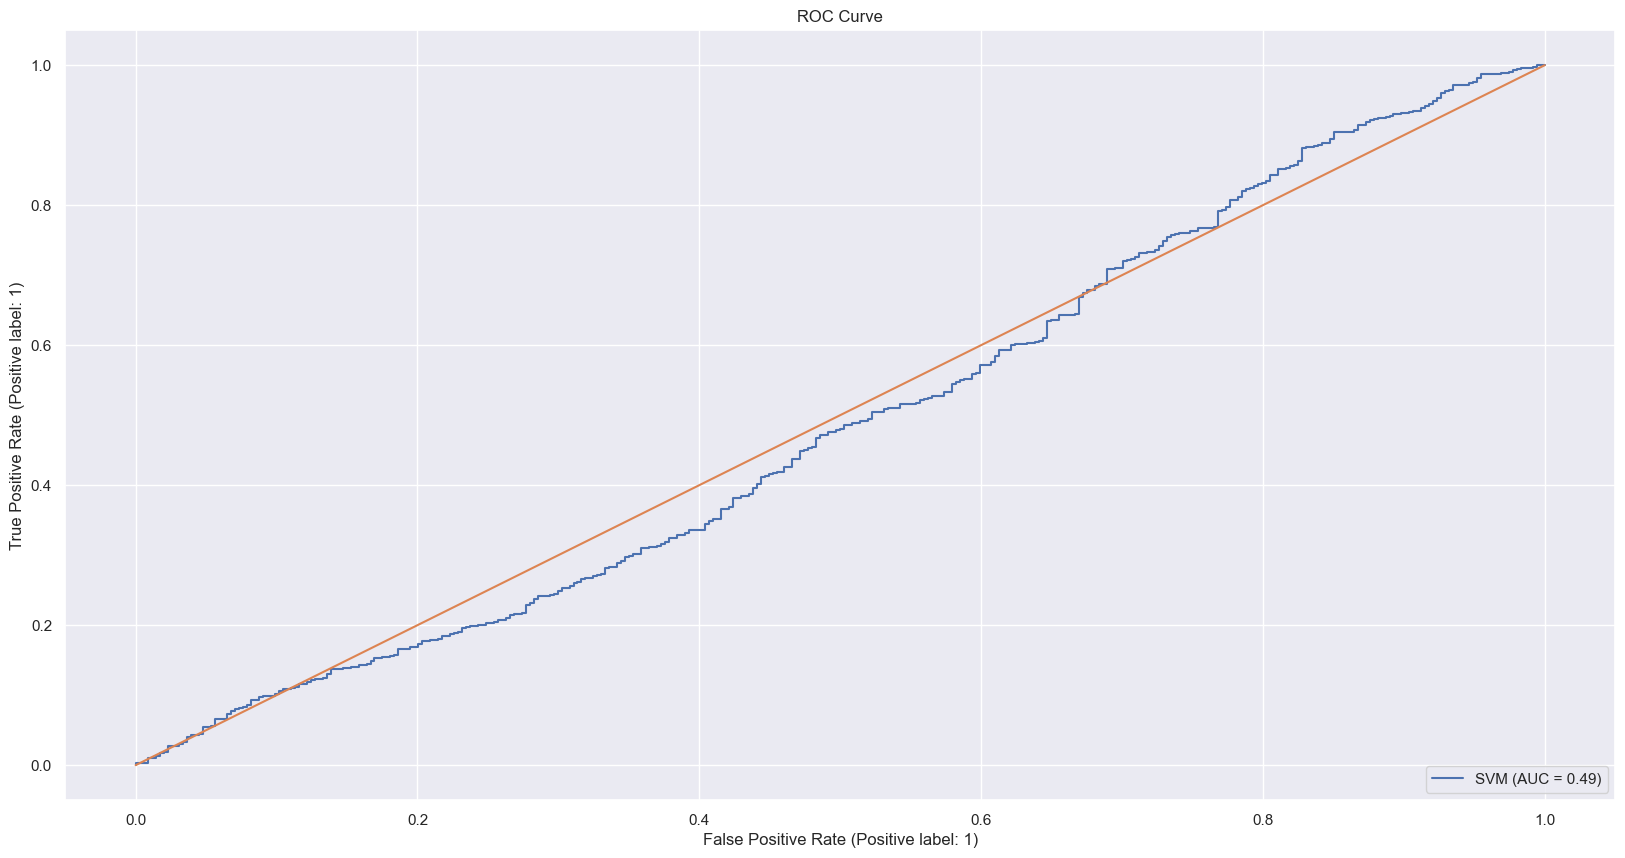

In [25]:
# Display ROCCurve
sp.roc_curve(SVC(), Normalizer())

<h3 align="center">Hyper-tuning</h3>
<h4 align="center">Kernel | Method | Hyperparameters</h4>

In [26]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [27]:
sp_model_norm.get_params()

{'memory': None,
 'steps': [('scaler', Normalizer()), ('svc', SVC())],
 'verbose': False,
 'scaler': Normalizer(),
 'svc': SVC(),
 'scaler__copy': True,
 'scaler__norm': 'l2',
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [28]:
param_grid = {'svc__degree': np.arange(1,20,1),
              'svc__kernel': ['rbf', 'linear', 'poly','sigmoid'],
              'svc__gamma': ['scale','auto'],
              'svc__probability': [False, True]}

grid_search = GridSearchCV(sp_model_norm, param_grid, scoring='roc_auc', n_jobs=multiprocessing.cpu_count()-1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 304 candidates, totalling 1520 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('svc', SVC())]),
             n_jobs=31,
             param_grid={'svc__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                         'svc__probability': [False, True]},
             scoring='roc_auc', verbose=1)

In [29]:
# Best Params & Scores
print(f"Optimal degree: {grid_search.best_params_['svc__degree']}, Best Score: {round(grid_search.best_score_,4)}")
print(f"Optimal kernel: {grid_search.best_params_['svc__kernel']}")
print(f"Optimal gamma: {grid_search.best_params_['svc__gamma']}")
print(f"Optimal probability: {grid_search.best_params_['svc__probability']}")

Optimal degree: 7, Best Score: 0.5429
Optimal kernel: poly
Optimal gamma: scale
Optimal probability: False


In [30]:
sp_model_norm_d7, sp_y_pred_norm_d7 = sp.fit_predict(SVC(kernel='poly', degree=7), Normalizer())
sp.eval_metrics(sp_model_norm_d7, sp_y_pred_norm_d7)

Train Accuracy: 0.71736, Test Accuracy: 0.70152, MSE:0.29848, RMSE:0.54634


In [31]:
print(classification_report(y_test, sp_y_pred_norm_d7))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       354
           1       0.70      1.00      0.82       832

    accuracy                           0.70      1186
   macro avg       0.35      0.50      0.41      1186
weighted avg       0.49      0.70      0.58      1186



C:\Users\renar\PycharmProjects\CQF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\renar\PycharmProjects\CQF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\renar\PycharmProjects\CQF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


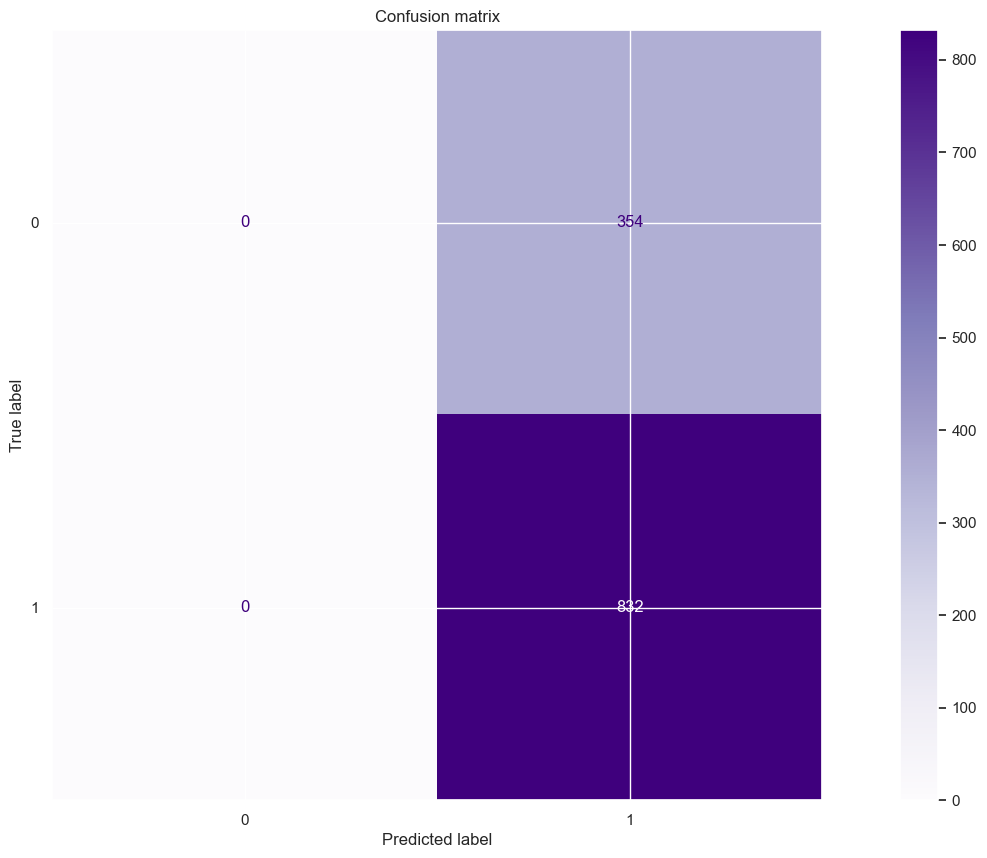

In [32]:
sp.confussion_matrix(SVC(kernel='poly', degree=7), Normalizer())

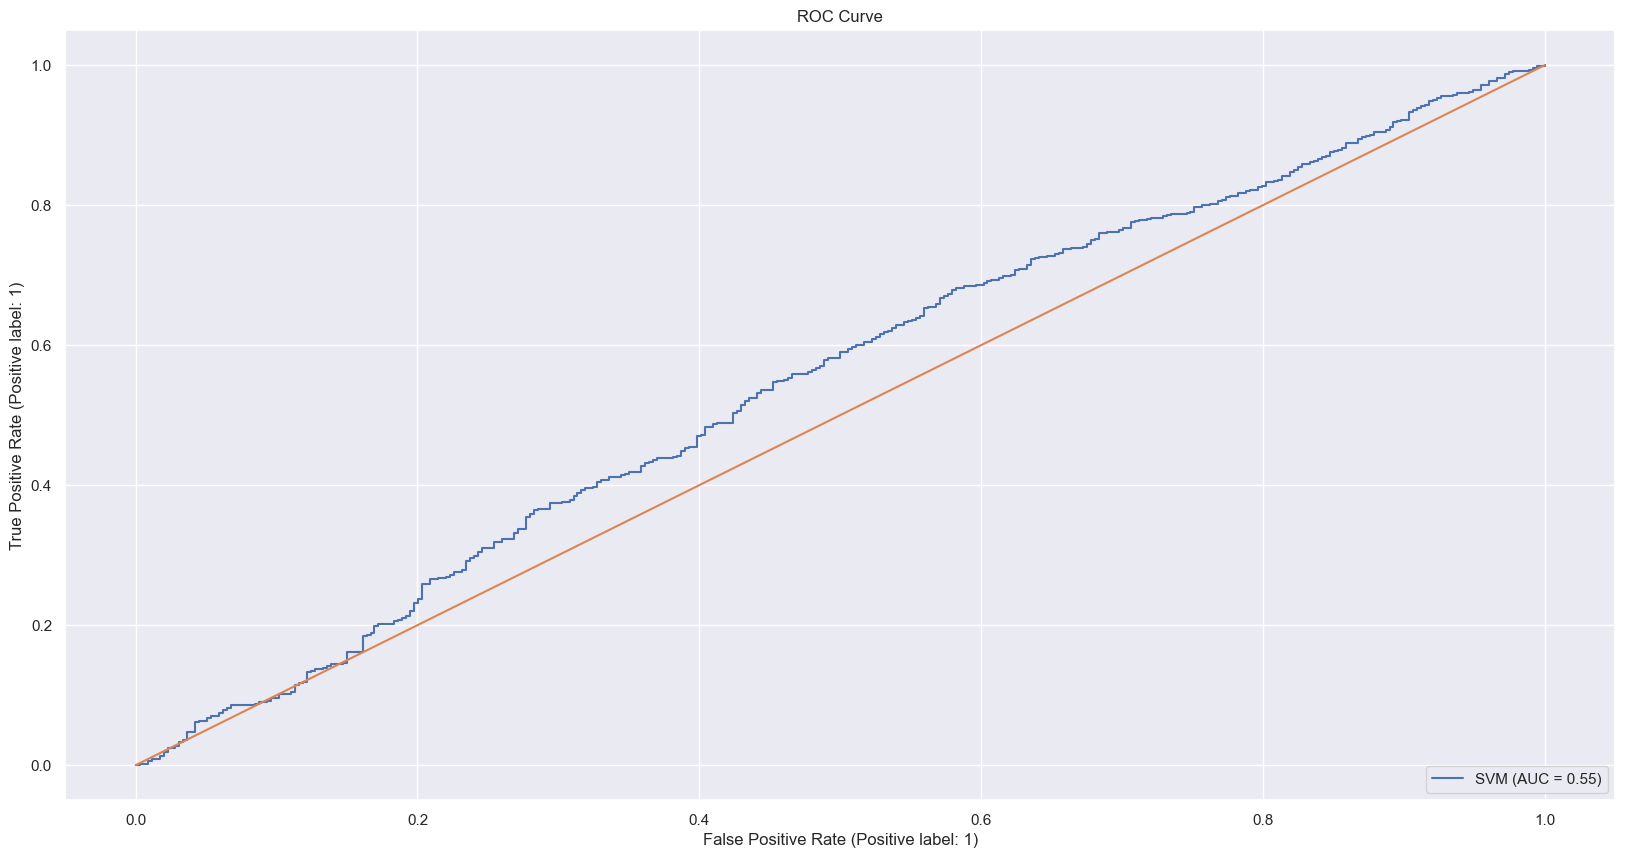

In [33]:
sp.roc_curve(SVC(kernel='poly', degree=7), Normalizer())